# Initializing and executing the machine-learning model

In this notebook, we will show how CoPro creates, trains, and tests a machine-learning model based on the settings and data shown in the previous notebooks.

## Preparations

Start with loading the required packages.

In [1]:
from copro import utils, pipeline, evaluation, plots, machine_learning

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sbs
import os, sys
from sklearn import metrics
from shutil import copyfile
import warnings
warnings.simplefilter("ignore")

For better reproducibility, the version numbers of all key packages used to run this notebook are provided.

In [2]:
utils.show_versions()

Python version: 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 01:53:57) [MSC v.1916 64 bit (AMD64)]
copro version: 0.0.8
geopandas version: 0.9.0
xarray version: 0.15.1
rasterio version: 1.1.0
pandas version: 1.0.3
numpy version: 1.18.1
scikit-learn version: 0.23.2
matplotlib version: 3.2.1
seaborn version: 0.11.0
rasterstats version: 0.14.0


To be able to also run this notebooks, some of the previously saved data needs to be loaded.

In [3]:
conflict_gdf = gpd.read_file(os.path.join('temp_files', 'conflicts.shp'))
selected_polygons_gdf = gpd.read_file(os.path.join('temp_files', 'polygons.shp'))

In [4]:
global_arr = np.load(os.path.join('temp_files', 'global_df.npy'), allow_pickle=True)
global_df = pd.DataFrame(data=global_arr, columns=['geometry', 'ID'])
global_df.set_index(global_df.ID, inplace=True)
global_df.drop(['ID'] , axis=1, inplace=True)

### The configurations-file (cfg-file)

To be able to continue the simulation with the same settings as in the previous notebook, the cfg-file has to be read again and the model needs to be initialised subsequently. This is not needed if CoPro is run from command line. Please see the first notebook for additional information. 

In [5]:
settings_file = 'example_settings.cfg'

In [6]:
main_dict, root_dir = utils.initiate_setup(settings_file, verbose=False)


#### CoPro version 0.0.8 ####
#### For information about the model, please visit https://copro.readthedocs.io/ ####
#### Copyright (2020-2021): Jannis M. Hoch, Sophie de Bruin, Niko Wanders ####
#### Contact via: j.m.hoch@uu.nl ####
#### The model can be used and shared under the MIT license ####

INFO: reading model properties from example_settings.cfg
INFO: verbose mode on: False
INFO: saving output to main folder C:\Users\hoch0001\Documents\_code\copro\example\./OUT


In [7]:
config_REF = main_dict['_REF'][0]
out_dir_REF = main_dict['_REF'][1] 

## Loading the XY-data

To avoid reading the XY-data again (see previous notebook for this), we can load the data directly from a `XY.npy` file which is automatically written to the output path. We saw that this file was created, but since no XY-data is specified in the config-file initially, we have to set the path manually. Note that this de-tour is only necessary due to the splitting of the workflow in different notebooks!

In [8]:
config_REF.set('pre_calc', 'XY', str(os.path.join(out_dir_REF, 'XY.npy')))

To double-check, see if the file manually specifid actually exists.

In [9]:
os.path.isfile(config_REF.get('pre_calc', 'XY'))

True

In [10]:
X, Y = pipeline.create_XY(config_REF, out_dir_REF, root_dir, selected_polygons_gdf, conflict_gdf)

INFO: loading XY data from file C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_REF\XY.npy


## Scaler and classifier

### Background

In principle, one can put all kind of data into the samples matrix X, leading to a wide spread of orders of magnitude, units, distributions etc. It is therefore needed to scale (or transform) the data in the X-array such that sensible comparisons and computations are possible. To that end, a scaling technique is applied.

Once there is a scaled X-array, a machine-learning model can be fitted with it together with the target values Y. 

### Implementation

CoPro supports four different scaling techniques. For more info, see the [scikit-learn documentation](https://scikit-learn.org/stable/getting_started.html#transformers-and-pre-processors).

1. MinMaxScaler;
2. StandardScaler;
3. RobustScaler;
4. QuantileTransformer.

From the wide range of machine-learning model, CoPro employs three different ones from the categorie of [supervised learning](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning).

1. NuSVC;
1. KNeighborsClassifier;
1. RFClassifier.

Note that CoPro uses pretty much the default parameterization of the scalers and models. An extensive [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) did not show any significant improvements when changing the parameters. There is currently no way to provide other parameters than those currently set.

Let's see which scaling technique and which supervised classifiers is specified for the example-run.

In [11]:
scaler, clf = pipeline.prepare_ML(config_REF)
print('As scaling technique, it is used: {}'.format(scaler))
print('As supervised classifing technique, it is used: {}'.format(clf))

As scaling technique, it is used: QuantileTransformer(random_state=42)
As supervised classifing technique, it is used: RandomForestClassifier(class_weight={1: 100}, n_estimators=1000,
                       random_state=42)


## Output initialization

Since the model is run multiple times to test various random train-test data combinations, we need to initialize a few lists first to append the output per run.

In [12]:
out_X_df = evaluation.init_out_df()
out_y_df = evaluation.init_out_df()

In [13]:
out_dict = evaluation.init_out_dict()

In [14]:
trps, aucs, mean_fpr = evaluation.init_out_ROC_curve()

## ML-model execution

The pudels kern! This is where the magic happens, and not only once. To make sure that any conincidental results are ruled out, we run the model multiple times. Thereby, always different parts of the XY-array are used for training and testing. By using a sufficient number of runs and averaging the overall results, we should be able to get a good picture of what the model is capable of. The number of runs as well as the split between training and testing data needs to be specified in the cfg-file.

Per repetition, the model is evaluated. The main evaluation metric is the mean ROC-score and [**ROC-curve**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html), plotted at the end of all runs. Additional evaluation metrics are computed as described below.

INFO: run 1 of 10


No handles with labels found to put in legend.


INFO: run 2 of 10


No handles with labels found to put in legend.


INFO: run 3 of 10


No handles with labels found to put in legend.


INFO: run 4 of 10


No handles with labels found to put in legend.


INFO: run 5 of 10


No handles with labels found to put in legend.


INFO: run 6 of 10


No handles with labels found to put in legend.


INFO: run 7 of 10


No handles with labels found to put in legend.


INFO: run 8 of 10


No handles with labels found to put in legend.


INFO: run 9 of 10


No handles with labels found to put in legend.


INFO: run 10 of 10


No handles with labels found to put in legend.


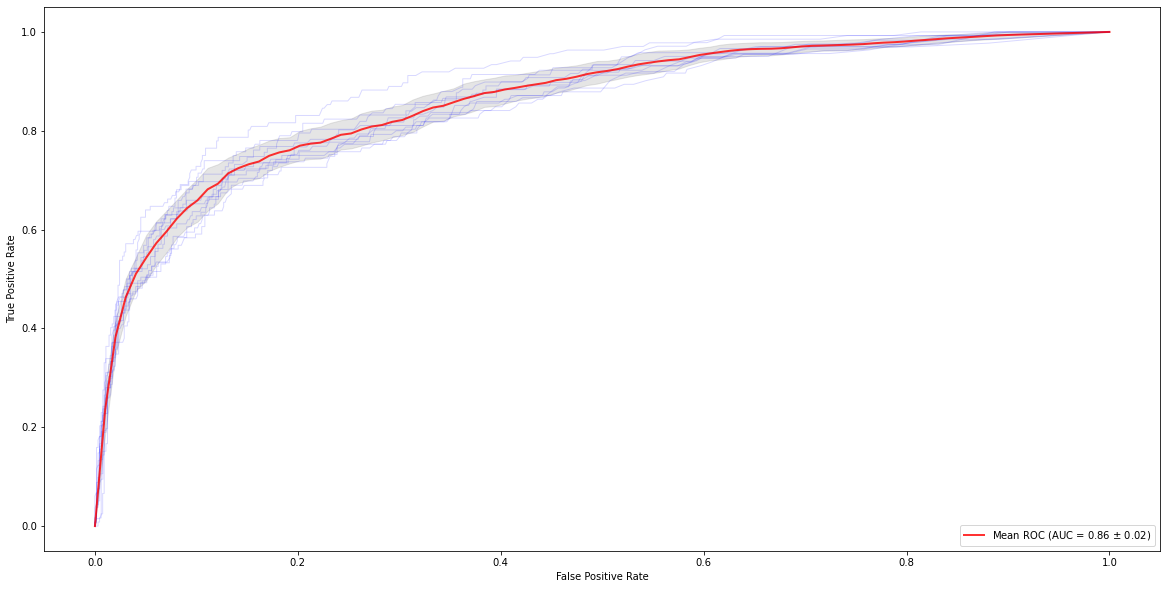

In [15]:
# #- create plot instance
fig, (ax1) = plt.subplots(1, 1, figsize=(20,10))

#- go through all n model executions
for n in range(config_REF.getint('machine_learning', 'n_runs')):
    
    print('INFO: run {} of {}'.format(n+1, config_REF.getint('machine_learning', 'n_runs')))

    #- run machine learning model and return outputs
    X_df, y_df, eval_dict = pipeline.run_reference(X, Y, config_REF, scaler, clf, out_dir_REF, run_nr=n+1)
    
    #- select sub-dataset with only datapoints with observed conflicts
    X1_df, y1_df = utils.get_conflict_datapoints_only(X_df, y_df)
    
    #- append per model execution
    out_X_df = evaluation.fill_out_df(out_X_df, X_df)
    out_y_df = evaluation.fill_out_df(out_y_df, y_df)
    out_dict = evaluation.fill_out_dict(out_dict, eval_dict)

    #- plot ROC curve per model execution
    tprs, aucs = plots.plot_ROC_curve_n_times(ax1, clf, X_df.to_numpy(), y_df.y_test.to_list(),
                                                                  trps, aucs, mean_fpr)

#- plot mean ROC curve
plots.plot_ROC_curve_n_mean(ax1, tprs, aucs, mean_fpr)

plt.savefig('../docs/_static/roc_curve.png', dpi=300, bbox_inches='tight')

## Model evaluation

### For all data points

During the model runs, the computed model evaluation scores per model execution were stored to a dictionary. Currently, the evaluation scores used are:

* [**Accuracy**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html): the fraction of correct predictions;
* [**Precision**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html): the ratio *tp / (tp + fp)* where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative;
* [**Recall**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html): the ratio *tp / (tp + fn)* where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples;
* [**F1 score**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html): the F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0;
* [**Cohen-Kappa score**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html): is used to measure inter-rater reliability. It is generally thought to be a more robust measure than simple percent agreement calculation, as κ takes into account the possibility of the agreement occurring by chance.
* [**Brier score**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html): the smaller the Brier score, the better, hence the naming with “loss”. The lower the Brier score is for a set of predictions, the better the predictions are calibrated. Note that the Brier loss score is relatively sensitive for imbalanced datasets;
* [**ROC score**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html): a value of 0.5 suggests no skill, e.g. a curve along the diagonal, whereas a value of 1.0 suggests perfect skill, all points along the left y-axis and top x-axis toward the top left corner. A value of 0.0 suggests perfectly incorrect predictions. Note that the ROC score is relatively insensitive for imbalanced datasets.
* [**AP score**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html): the average_precision_score function computes the average precision (AP) from prediction scores. The value is between 0 and 1 and higher is better.

Let's check the mean scores over all runs:

In [16]:
for key in out_dict:
    
    print('average {0} of run with {1} repetitions is {2:0.3f}'.format(key, config_REF.getint('machine_learning', 'n_runs'), np.mean(out_dict[key])))

average Accuracy of run with 10 repetitions is 0.885
average Precision of run with 10 repetitions is 0.723
average Recall of run with 10 repetitions is 0.505
average F1 score of run with 10 repetitions is 0.593
average Cohen-Kappa score of run with 10 repetitions is 0.529
average Brier loss score of run with 10 repetitions is 0.090
average ROC AUC score of run with 10 repetitions is 0.863
average AP score of run with 10 repetitions is 0.633


So how are, e.g. accuracy, precision, and recall distributed?

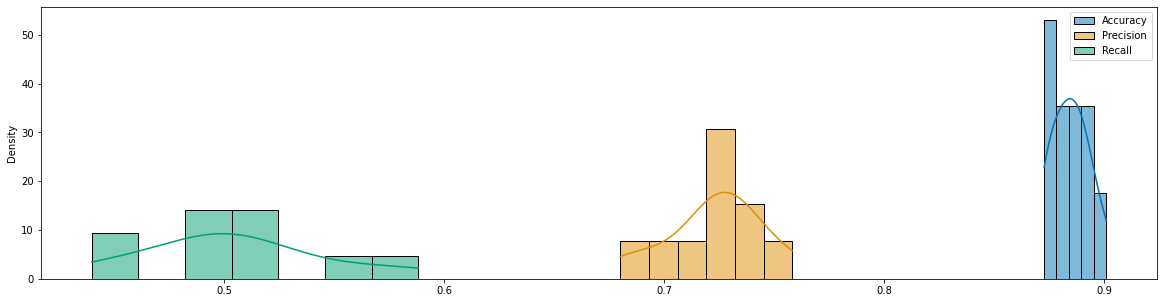

In [17]:
plots.metrics_distribution(out_dict, metrics=['Accuracy', 'Precision', 'Recall'], figsize=(20, 5));

Based on all data points, the [**confusion matrix**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) can be plotted. This is a relatively straightforward way to visualize how good (i.e. correct) the observations are predicted by the model. Ideally, all `True label` and `Predicted label` pairs have the highest values.

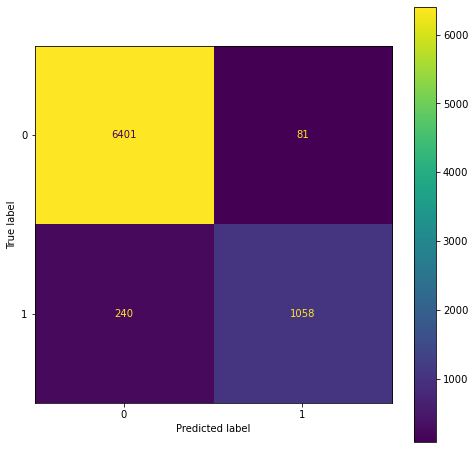

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
metrics.plot_confusion_matrix(clf, out_X_df.to_numpy(), out_y_df.y_test.to_list(), ax=ax);

In `out_y_df`, all predictions are stored. This includes the actual value `y_test` (ie. whether a conflict was observed or not) and the predicted outcome `y_pred` together with the probabilities of this outcome. Additionally, CoPro adds a column with a Boolean indicator whether the predictions was correct (`y_test=y_pred`) or not.

In [19]:
out_y_df.head()

,ID,geometry,y_test,y_pred,y_prob_0,y_prob_1,correct_pred
0,445,"(POLYGON ((34 -6.270833332991856, 34.004166666...",0,0,0.989,0.011,1
1,1102,POLYGON ((18.13945463942014 -21.76666666653341...,0,0,0.99,0.01,1
2,962,POLYGON ((-0.5123387189566415 15.0858593763092...,0,0,0.922,0.078,1
3,1017,"POLYGON ((36.25833319502101 17.03237808058401,...",0,0,0.851,0.149,1
4,80,"POLYGON ((30.81249977574413 21.998945056769, 3...",0,0,0.996,0.004,1


### Per unique polygon

Thus far, we merely looked at numerical scores for all predcitions. This of course tells us a lot about the quality of the machine-learning model, but not so much about how this looks like spatially. We therefore combine the observations and predictions made with the associated polygons based on a 'global' dataframe functioning as a look-up table. By this means, each model prediction (ie. each row in `out_y_df`) can be connected to its polygon using a unique polygon-ID.

In [20]:
df_hit, gdf_hit = evaluation.polygon_model_accuracy(out_y_df, global_df)

First, let's have a look at how often each polygon occurs in the all test samples, i.e. those obtained by appending the test samples per model execution. Besides, the overall relative distribution is visualized.

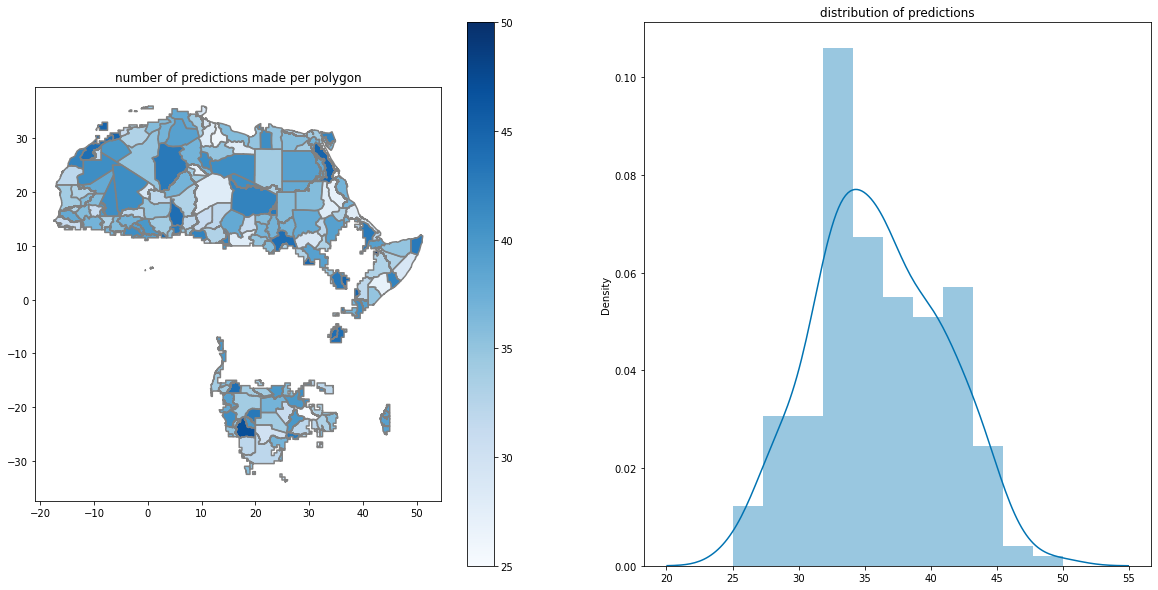

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
gdf_hit.plot(ax=ax1, column='nr_predictions', legend=True, cmap='Blues')
selected_polygons_gdf.boundary.plot(ax=ax1, color='0.5')
ax1.set_title('number of predictions made per polygon')
sbs.distplot(df_hit.nr_predictions.values, ax=ax2)
ax2.set_title('distribution of predictions');

By repeating the model *n* times, the aim is to represent all polygons in the resulting test sample. The fraction is computed below. 

Note that is should be close to 100 % but may be slightly less. This can happen if input variables have no data for one polygon, leading to a removal of those polygons from the analysis. Or because some polygons and input data may not overlap.

In [22]:
print('{0:0.2f} % of all active polygons are considered in test sample'.format(len(gdf_hit)/len(selected_polygons_gdf)*100))

100.00 % of all active polygons are considered in test sample


By aggregating results per polygon, we can now assess model output spatially. Three main aspects are presented here:

1. The total number of conflict events per water province;
2. The chance of a correct prediction, defined as the ratio of number of correct predictions made to overall number of predictions made;
3. The mean conflict probability, defined as the mean value of all probabilites of conflict to occur (y_prob_1) in a polygon.

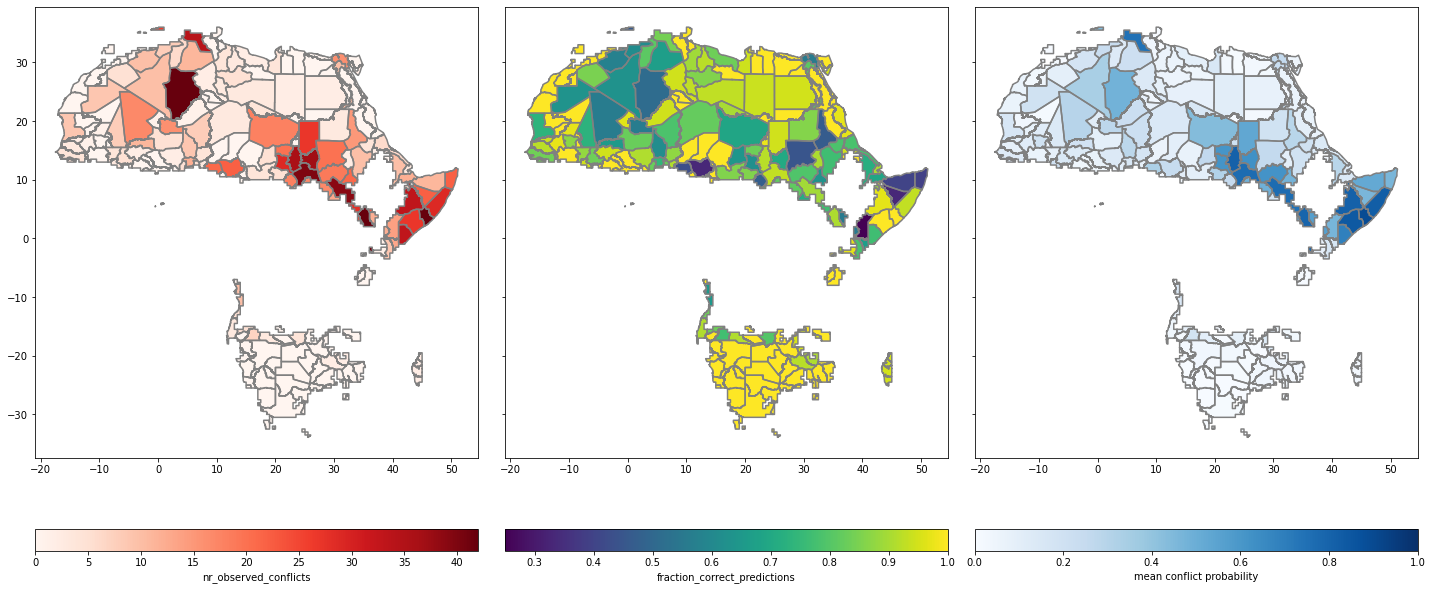

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(20, 20), sharex=True, sharey=True)

gdf_hit.plot(ax=axes[0], column='nr_observed_conflicts', legend=True, cmap='Reds', 
             legend_kwds={'label': "nr_observed_conflicts", 'orientation': "horizontal", 'fraction': 0.045, 'pad': 0.05})
selected_polygons_gdf.boundary.plot(ax=axes[0], color='0.5')

gdf_hit.plot(ax=axes[1], column='fraction_correct_predictions', legend=True, 
             legend_kwds={'label': "fraction_correct_predictions", 'orientation': "horizontal", 'fraction': 0.045, 'pad': 0.05})
selected_polygons_gdf.boundary.plot(ax=axes[1], color='0.5')

gdf_hit.plot(ax=axes[2], column='avg_prob_1', legend=True, cmap='Blues', vmin=0, vmax=1, 
             legend_kwds={'label': "mean conflict probability", 'orientation': "horizontal", 'fraction': 0.045, 'pad': 0.05})
selected_polygons_gdf.boundary.plot(ax=axes[2], color='0.5')

plt.tight_layout();

## Preparing for projections

In this notebook, we have trained and tested our model with various combinations of data. Subsequently, the average performance of the model was evaluated with a range of metrics.

If we want to re-use our model for the future and want to make projections, it is necessary to save the model (that is, the *n* fitted classifiers). They can then be loaded and one or more projections can be made with other variable values than those used for this reference run.

To that end, the classifier is fitted again, but then with all data, i.e. without a split-sample test. That way, the classifier fit is most robust.

In [24]:
%%capture

for root, dirs, files in os.walk(os.path.join(out_dir_REF, 'clfs')):
    for file in files:
        fname = file
        print(fname)
        copyfile(os.path.join(out_dir_REF, 'clfs', str(fname)),
                 os.path.join('temp_files', str(fname)))